In [1]:
import pandas as pd#导入csv文件的库
import numpy as np#进行矩阵运算的库
import matplotlib.pyplot as plt#作图的库

import torch#一个深度学习的库Pytorch
import torch.nn as nn#neural network,神经网络
import torch.optim as optim#一个实现了各种优化算法的库
import torch.nn.functional as F#神经网络函数库

import os#与操作系统交互,处理文件和目录、管理进程、获取环境变量
from PIL import Image, ImageOps, ImageFilter, ImageEnhance#PIL是图像处理库 ImageEnhance数据增强,ImageFilter滤镜

In [2]:
#设置随机种子
import random
torch.backends.cudnn.deterministic = True#将cudnn框架中的随机数生成器设为确定性模式
torch.backends.cudnn.benchmark = False#关闭CuDNN框架的自动寻找最优卷积算法的功能，以避免不同的算法对结果产生影响
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
path_imgs="/kaggle/input/opencv-pytorch-course-segmentation/imgs/imgs/"
path_masks="/kaggle/input/opencv-pytorch-course-segmentation/masks/masks/"

In [4]:
def getPhoto(path_photo):
    files_list = sorted(os.listdir(path_photo))
    return files_list

In [5]:
imgfile=getPhoto(path_imgs)
maskfile=getPhoto(path_masks)
print(f"len(imgfile):{len(imgfile)},len(maskfile):{len(maskfile)}")

len(imgfile):3269,len(maskfile):2621


In [6]:
dataX=[]
datay=[]
for index in range(1000):#len(maskfile)
        img=Image.open(path_imgs+maskfile[index][:-3]+"jpg")
        img=np.array(img)
        mask=Image.open(path_masks+maskfile[index])
        mask=np.array(mask)
        dataX.append(img)
        datay.append(mask)
dataX=np.array(dataX)
datay=np.array(datay)
print(f"dataX.shape:{dataX.shape},datay.shape:{datay.shape}" )  

dataX.shape:(1000, 720, 1280, 3),datay.shape:(1000, 720, 1280)


In [7]:
def plot_segmentation(img,mask):
    colors={"0":(255, 0, 0),"1":(255, 165, 0),"2":(255, 255, 0),"3":(0, 128, 0),
            "4": (255, 255, 255),"5":(0, 0, 255),"6":(128, 0, 128),"7":(255, 192, 203),
            "8":(0, 0, 0),"9":(165, 42, 42),"10":(128, 128, 128),"11":(0,255,255)
           }
    h,w=mask.shape
    mask_img=np.zeros((h,w,3))
    for i in range(h):
        for j in range(w):
            c1,c2,c3=colors[str(mask[i][j])]#3个通道的颜色值
            mask_img[i][j][0]=c1
            mask_img[i][j][1]=c2
            mask_img[i][j][2]=c3
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(mask_img)

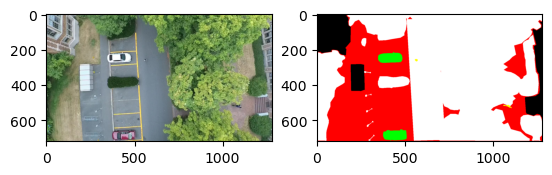

In [8]:
plot_segmentation(dataX[0],datay[0])

In [9]:
dataX=np.transpose(dataX,(0,3,1,2))

In [10]:
#划分训练集和测试集的函数
def train_test_split(dataX,datay,shuffle=True,percentage=0.8):
    """
    将训练数据X和标签y以numpy.array数组的形式传入
    划分的比例定为训练集:测试集=8:2
    """
    if shuffle:
        random_num=[index for index in range(len(dataX))]
        np.random.shuffle(random_num)
        dataX=dataX[random_num]
        datay=datay[random_num]
    split_num=int(len(dataX)*percentage)
    train_X=dataX[:split_num]
    train_y=datay[:split_num]
    test_X=dataX[split_num:]
    test_y=datay[split_num:]
    return train_X,train_y,test_X,test_y

In [11]:
train_X,train_y,valid_X,valid_y=train_test_split(dataX,datay,percentage=0.9)
print(f"train_X.shape:{train_X.shape},valid_X.shape:{valid_X.shape}")

train_X.shape:(900, 3, 720, 1280),valid_X.shape:(100, 3, 720, 1280)


In [12]:
num_classes=12
encoder=nn.Sequential(
   nn.Conv2d(3,32,4,2,1),#360*640
   nn.BatchNorm2d(32),
   nn.GELU(),
   nn.Conv2d(32,64,4,2,1),#180*320
   nn.BatchNorm2d(64),
   nn.GELU(),
   nn.Conv2d(64,128,4,2,1),#90*160
   nn.BatchNorm2d(128),
   nn.GELU(),
   nn.Conv2d(128,256,4,2,1),#45*80
   nn.BatchNorm2d(256),
   nn.GELU(),
)

decoder=nn.Sequential(
   nn.ConvTranspose2d(256,128,4,2,1),
   nn.BatchNorm2d(128),
   nn.Tanh(),
   nn.ConvTranspose2d(128,64,4,2,1),
   nn.BatchNorm2d(64),
   nn.Tanh(),
   nn.ConvTranspose2d(64,32,4,2,1),
   nn.BatchNorm2d(32),
   nn.Tanh(),
   nn.ConvTranspose2d(32,num_classes,4,2,1),
   nn.BatchNorm2d(num_classes),
)

In [13]:
class U_net(nn.Module):
    def __init__(self):
        
        super(U_net,self).__init__()
        
        self.conv=nn.Sequential(
        encoder,
        decoder,
        )

    def forward(self,input): 
        output=self.conv(input)#b,c,h,w
        return F.softmax(output,dim=1)

In [14]:
device='cuda' if torch.cuda.is_available() else"cpu"
print(f"device:{device}")

netC=U_net()
#训练次数
num_epochs=200
batch_size=10#一次训练数据的训练量
#优化器
optimizer=optim.Adam(netC.parameters(),lr=0.00025,betas=(0.5,0.999))
#损失函数
criterion=nn.MSELoss()

netC.to(device)

device:cpu


U_net(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
      (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): GELU(approximate='none')
      (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): GELU(approximate='none')
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Ba

In [15]:
%%time

train_accs=[]
valid_accs=[]

valid_X1=torch.Tensor(valid_X).to(device)

for epoch in range(num_epochs):
    
    random_num=[index for index in range(len(train_X))]
    np.random.shuffle(random_num)
    
    train_X=train_X[random_num]
    train_y=train_y[random_num]
    
    train_X1=torch.Tensor(train_X[:batch_size]).to(device)
    
    b,h,w=train_y.shape
    train_y1=np.zeros((batch_size,num_classes,h,w))
    for i in range(batch_size):
        for j in range(h):
            for k in range(w):
                train_y1[i][train_y[i][j][k]][j][k]=1
    train_y1=torch.Tensor(train_y1).to(device)
    #训练
    netC.train()
    #将梯度清空
    optimizer.zero_grad()
    #将数据放进去训练
    output=netC(train_X1).to(device)
    #计算每次的损失函数
    loss=criterion(output,train_y1).to(device)
    #反向传播
    loss.backward()
    #优化器进行优化(梯度下降,降低误差)
    optimizer.step()
    netC.eval()
    with torch.no_grad():
        train_pred=netC(train_X1).to(device)
        train_pred=train_pred.detach().cpu().numpy()
        train_pred=np.argmax(train_pred,axis=1)
        t_b,t_h,t_w=train_pred.shape
        
        valid_pred=netC(valid_X1).to(device)
        valid_pred=valid_pred.detach().cpu().numpy()
        valid_pred=np.argmax(valid_pred,axis=1)
        v_b,v_h,v_w=valid_pred.shape
    train_acc=np.sum(train_pred==train_y[:batch_size])/(t_b*t_h*t_w)
    valid_acc=np.sum(valid_pred==valid_y)/(v_b*v_h*v_w)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    print(f"epoch:{epoch},loss:{loss}\n train_acc:{train_acc},valid_acc:{valid_acc}")

epoch:0,loss:0.08336661756038666
 train_acc:0.22261100260416666,valid_acc:0.2508063151041667
epoch:1,loss:0.0801841989159584
 train_acc:0.21304915364583332,valid_acc:0.2518659939236111
epoch:2,loss:0.0768696740269661
 train_acc:0.26746473524305553,valid_acc:0.2669050347222222
epoch:3,loss:0.07526994496583939
 train_acc:0.2744144965277778,valid_acc:0.27621497395833333
epoch:4,loss:0.07119578868150711
 train_acc:0.2862827690972222,valid_acc:0.24828052300347223
epoch:5,loss:0.07018551975488663
 train_acc:0.3075055338541667,valid_acc:0.26525108506944445
epoch:6,loss:0.06688057631254196
 train_acc:0.2936310763888889,valid_acc:0.27303463541666667
epoch:7,loss:0.0685977190732956
 train_acc:0.29912923177083334,valid_acc:0.31551388888888887
epoch:8,loss:0.06664108484983444
 train_acc:0.3675690104166667,valid_acc:0.36715270182291665
epoch:9,loss:0.06448964029550552
 train_acc:0.4364289279513889,valid_acc:0.3973625651041667
epoch:10,loss:0.06414558738470078
 train_acc:0.38435959201388886,valid_ac

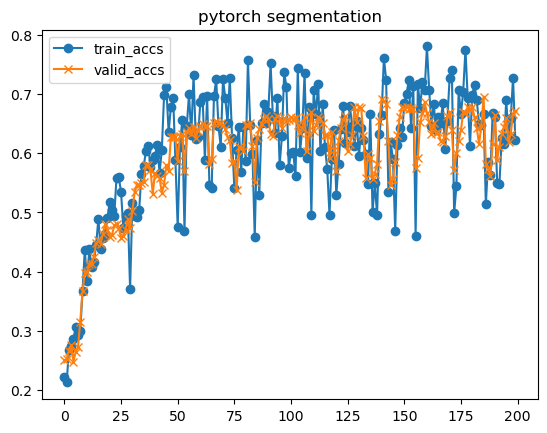

In [16]:
epochs=[i for i in range(len(train_accs))]
plt.title("pytorch segmentation")
plt.plot(epochs,train_accs,marker="o",label="train_accs")
plt.plot(epochs,valid_accs,marker="x",label="valid_accs")
plt.legend()
plt.show()

/tmp/ipykernel_20/4186889451.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  valid_X1=torch.Tensor([valid_X[0]])


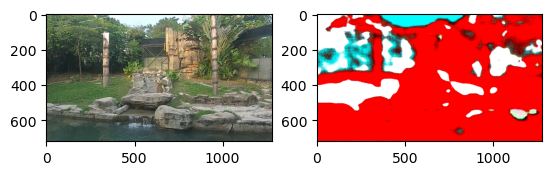

In [17]:
valid_X1=torch.Tensor([valid_X[0]])
valid_pred=netC(valid_X1).to(device)
valid_pred=valid_pred.detach().cpu().numpy()
img=np.transpose(valid_X[0],(1,2,0))
valid_pred=np.argmax(valid_pred,axis=1)[0]
plot_segmentation(img,valid_pred)

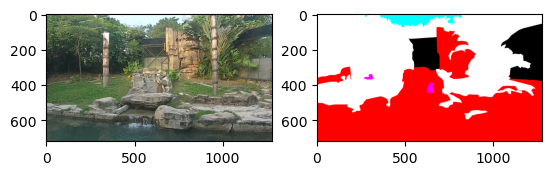

In [18]:
plot_segmentation(img,valid_y[0])